# CHASV_60model.v2.1
split 7:3

In [129]:
SEED = 0
cores = 16

from numpy.random import seed
seed(SEED)
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from collections import Counter
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
from xgboost import plot_importance
from matplotlib import pyplot as plt
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import classification_report
import shap
from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
import seaborn as sns
import joblib
from BorutaShap import BorutaShap
import tqdm

# version check
import sys
print("python version")
print(sys.version)
import sklearn
print("sklearn version = ", sklearn.__version__)
print("numpy version = ", np.__version__)
print("pandas version =", pd.__version__)

python version
3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
sklearn version =  0.23.2
numpy version =  1.19.2
pandas version = 1.2.3


In [2]:
df = pd.read_csv("/home/danssa/proj_ua/data/chasv_development.v1.csv", dtype={'id':np.str})
df2 = df.loc[df['from']!="knhanes"]
df2.describe()

,eGFR_ab,eGFR_ckd,male,age,he_uph,he_unitr,he_usg,he_upro,he_uglu,he_uket,he_ubil,he_ubld,he_uro,leucocyte,dm,htn
count,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000,220020.000000
mean,0.067598,93.719380,0.428929,47.179829,6.183206,0.020280,1.018628,0.331024,0.234011,0.205590,0.039356,0.757068,0.168417,0.516135,0.025325,0.039046
std,0.251056,22.147902,0.494924,15.570474,0.824044,0.140957,0.007915,0.769946,0.888690,0.669646,0.324305,1.252923,0.560018,1.024153,0.157111,0.193706
min,0.000000,1.704754,0.000000,18.000000,5.000000,0.000000,1.005000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,80.803010,0.000000,35.000000,5.500000,0.000000,1.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,95.813740,0.000000,45.000000,6.000000,0.000000,1.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,110.264000,1.000000,58.000000,7.000000,0.000000,1.025000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,257.176000,1.000000,95.000000,9.000000,1.000000,1.030000,5.000000,5.000000,5.000000,4.000000,5.000000,5.000000,4.000000,1.000000,1.000000


In [3]:
#3group age split  

##step 1 finding edge value
abnormal_disc = df2.query('eGFR_ab==1').loc[:,'age']
abnormal_disc = pd.DataFrame(abnormal_disc)

est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')
est.fit(abnormal_disc)

ab_disc = est.transform(abnormal_disc).astype('float')
print("edges : ", est.bin_edges_[0])

age0_edge = est.bin_edges_[0][1]
age1_edge = est.bin_edges_[0][2]
age2_edge = est.bin_edges_[0][3]
print('age0_edge:', age0_edge, '\nage1_edge:', age1_edge, '\nage2_edge:', age2_edge)

abnormal_disc['level'] = abnormal_disc.apply(lambda x : 0 if x['age']<age0_edge else 1 if x['age']<age1_edge else 2, axis=1)
print('age group:\n',abnormal_disc['level'].value_counts().sort_index())

edges :  [18.         53.80721514 70.94886739 95.        ]
age0_edge: 53.80721513971053 
age1_edge: 70.94886739427912 
age2_edge: 95.0
age group:
 0    2104
1    5505
2    7264
Name: level, dtype: int64


In [4]:
##make 3group by age
df3 = df2.copy()

##age cut set up
df3['level'] = df3.apply(lambda x : 0 if x['age']<age0_edge else 1 if x['age']<age1_edge else 2, axis=1)
print(df3['level'].value_counts())

0    147140
1     52377
2     20503
Name: level, dtype: int64


In [5]:
##age0 group
X_age0 = df3[df3['level']==0]
y_age0 = X_age0['eGFR_ab'].astype("int64")

print('\nage0', X_age0['age'].min(), X_age0['age'].max())
print("total cases = %d" %X_age0.shape[0])
print("total abnormal function of kidney = %d" %sum(y_age0), "\nprevalence =", sum(y_age0)/len(y_age0)*100)

X_train0, X_test0, y_train0, y_test0 = train_test_split(X_age0, y_age0, test_size=0.3, stratify=y_age0, random_state=SEED)
print("train0 : %d" % sum(y_train0), "test0 : %d" % sum(y_test0))

##age1 group
X_age1 = df3[df3['level']==1]
y_age1 = X_age1['eGFR_ab']

print('\nage1', X_age1['age'].min(), X_age1['age'].max())
print("total cases = %d" %X_age1.shape[0])
print("total abnormal function of kidney = %d" %sum(y_age1), "\nprevalence =", sum(y_age1)/len(y_age1)*100)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_age1, y_age1, test_size=0.3, stratify=y_age1, random_state=SEED)
print("train1 : %d" % sum(y_train1), "test1 : %d" % sum(y_test1))

##age2 group
X_age2 = df3[df3['level']==2]
y_age2 = X_age2['eGFR_ab']

print('\nage2', X_age2['age'].min(), X_age2['age'].max())
print("total cases = %d" %X_age2.shape[0])
print("total abnormal function of kidney = %d" %sum(y_age2), "\nprevalence =", sum(y_age2)/len(y_age2)*100)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_age2, y_age2, test_size=0.3, stratify=y_age2, random_state=SEED)
print("train2 : %d" % sum(y_train2), "test2 : %d" % sum(y_test2))


age0 18 53
total cases = 147140
total abnormal function of kidney = 2104 
prevalence = 1.4299306782655974
train0 : 1473 test0 : 631

age1 54 70
total cases = 52377
total abnormal function of kidney = 5505 
prevalence = 10.510338507360101
train1 : 3853 test1 : 1652

age2 71 95
total cases = 20503
total abnormal function of kidney = 7264 
prevalence = 35.42896161537336
train2 : 5085 test2 : 2179


In [6]:
##concat both trainset and testset
X_train = pd.concat([X_train0, X_train1, X_train2])
y_train = pd.concat([y_train0, y_train1, y_train2])

X_test = pd.concat([X_test0, X_test1, X_test2])
y_test = pd.concat([y_test0, y_test1, y_test2])

print("total cases = %d" % (X_train.shape[0] + X_test.shape[0]))
print("total abnormal function of kidney = %d" % (sum(y_train) + sum(y_test)), "\nprevalence =", (sum(y_train)+sum(y_test))/(len(y_train)+len(y_test))*100)

total cases = 220020
total abnormal function of kidney = 14873 
prevalence = 6.759840014544133


In [7]:
# for psm 
#X_test.to_csv("~/proj_ua/data/cha_test_psm.csv", index=False)

In [8]:
X_train_features = X_train.loc[:, 'male':'leucocyte']

print('%d train cases, %d variables' % (X_train_features.shape[0], X_train_features.shape[1]))
print('%d test cases'%X_test.shape[0])

154013 train cases, 12 variables
66007 test cases


In [9]:
#standardization

scaler = StandardScaler()
std_cols=['age','he_uph','he_usg']
std_df=X_train_features[std_cols]

X_train_features[std_cols]=scaler.fit_transform(std_df)
X_train_features.describe()

,male,age,he_uph,he_unitr,he_usg,he_upro,he_uglu,he_uket,he_ubil,he_ubld,he_uro,leucocyte
count,154013.000000,1.540130e+05,1.540130e+05,154013.000000,1.540130e+05,154013.000000,154013.000000,154013.000000,154013.000000,154013.000000,154013.000000,154013.000000
mean,0.428990,-2.362125e-17,3.380791e-16,0.020492,-1.550439e-14,0.330505,0.234565,0.206749,0.039802,0.754339,0.167538,0.518443
std,0.494933,1.000003e+00,1.000003e+00,0.141676,1.000003e+00,0.768392,0.888223,0.670159,0.325684,1.251279,0.558978,1.026045
min,0.000000,-1.875173e+00,-1.435489e+00,0.000000,-1.720897e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-7.828201e-01,-8.290850e-01,0.000000,-1.089132e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,-1.402599e-01,-2.226811e-01,0.000000,1.743975e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,6.950684e-01,9.901268e-01,0.000000,8.061624e-01,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,1.000000,3.072541e+00,3.415742e+00,1.000000,1.437927e+00,5.000000,5.000000,5.000000,4.000000,5.000000,4.000000,4.000000


In [10]:
#model fit and mean accuracy
def evaluate_model(X, y, model):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=8, random_state=SEED)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=cores)
    return scores

#model : chasv_60model.v1
model = XGBClassifier(colsample_bytree=0.8000000000000002, gamma=2.0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=500, 
                        objective="binary:logistic", reg_alpha=0, reg_lambda=1, scale_pos_weight=14, subsample=0.2,
                        nthread=6, random_state=SEED).fit(X_train_features, y_train)
scores = evaluate_model(X_train_features, y_train, model)
print('Mean AUC: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean AUC: 0.915 (0.003)


In [11]:
# dimensionality reduction using feature importance
df_imp = pd.DataFrame({'imp':model.feature_importances_}, index = model.get_booster().feature_names)
df_imp = df_imp[df_imp.imp > 0].sort_values('imp').copy()

feat_num = df_imp.shape[0]
print("total number of features =", feat_num)
df_imp

total number of features = 12


,imp
he_uro,0.022157
leucocyte,0.024069
he_uket,0.024328
he_ubil,0.028265
male,0.040014
he_unitr,0.043089
he_uglu,0.056432
he_ubld,0.056874
he_uph,0.057655
he_usg,0.062921


In [12]:
# new model 

## new trainset
X_train_features_new = X_train_features.loc[:, ['male', 'he_usg', 'he_uph', 'he_ubld', 'he_uglu', 'he_upro', 'age']]

## model: chasv_60model.v1
model_new = XGBClassifier(colsample_bytree=0.8000000000000002, gamma=2.0, learning_rate=0.01, max_depth=3, min_child_weight=2, n_estimators=500, 
                        objective="binary:logistic", reg_alpha=0, reg_lambda=1, scale_pos_weight=14, subsample=0.2,
                           nthread=6, random_state=SEED).fit(X_train_features_new, y_train)
scores_new = evaluate_model(X_train_features_new, y_train, model_new)
print('Mean AUC of new model : %.3f (%.3f)' % (mean(scores_new), std(scores_new)))

Mean AUC of new model : 0.914 (0.003)


## internal and external validation, All

### internal bootstrap

In [70]:
#testset proteinuria
X_test_features = X_test.loc[:, ['male', 'he_usg', 'he_uph', 'he_ubld', 'he_uglu', 'he_upro', 'age']]
std_df=X_test_features[std_cols]
X_test_features[std_cols]=scaler.transform(std_df)

In [71]:
# dataframe for bootstrap
y_prob = model_new.predict_proba(X_test_features)[:,1]
X_test_bs = X_test.copy()
X_test_bs['prob'] = y_prob
X_test_bs

,id,eGFR_ab,eGFR_ckd,male,age,he_uph,he_unitr,he_usg,he_upro,he_uglu,he_uket,he_ubil,he_ubld,he_uro,leucocyte,from,dm,htn,level,prob
664,10509866,0,86.150783,1,52,7.5,0,1.015,0,0,0,0,0,0,0.0,cha,0,0,0,0.182862
93596,11407061,1,55.096350,0,44,7.0,0,1.005,0,0,0,0,0,0,0.0,cha,0,0,0,0.070407
29883,10872259,0,117.372900,1,33,5.5,0,1.025,0,0,0,0,0,0,0.0,cha,0,0,0,0.045959
18763,10730770,0,92.991350,0,19,5.0,0,1.025,2,0,0,0,2,0,3.0,cha,0,0,0,0.257934
187422,11843382,0,99.844700,1,31,6.0,0,1.030,0,0,0,0,0,0,0.0,cha,0,0,0,0.026850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276135,2200203,1,40.405114,1,90,5.0,0,1.015,1,2,0,0,0,1,0.0,sv,0,0,2,0.960947
179982,10974687,1,51.895710,1,79,5.5,0,1.010,0,0,0,0,0,0,0.0,cha,0,0,2,0.880740
121678,10704951,0,70.768210,1,80,5.0,0,1.010,1,0,0,0,3,0,0.0,cha,0,0,2,0.956982
45533,11062770,0,62.748080,0,75,5.0,0,1.005,1,0,0,0,4,0,0.0,cha,0,0,2,0.941138


In [15]:
# test set
data = X_test_bs

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box = []
th_box = []
se_box = []
sp_box = []

for i in range(n_iterations):
    boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
    auc = roc_auc_score(boot['eGFR_ab'], boot['prob'])
    
    auc_box.append(auc)
    
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(boot['eGFR_ab'], boot['prob'])
    J = tpr - fpr
    ix = argmax(J)
    best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
    
    th_box.append(best_thresh)
    se_box.append(se)
    sp_box.append(sp)

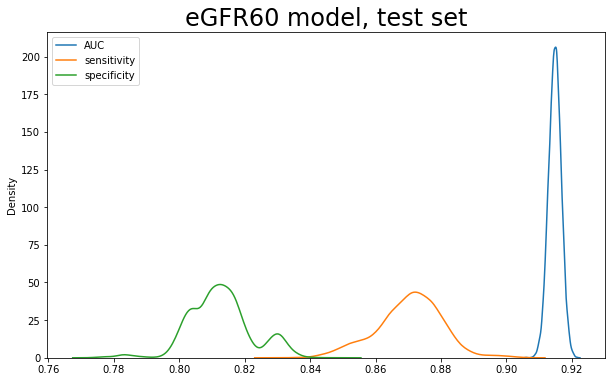

auc mean: 0.91 (0.91-0.92), median:0.91
se  mean: 0.87 (0.85-0.89), median:0.87
sp  mean: 0.81 (0.80-0.83), median:0.81
th  mean: 0.48 (0.45-0.54), median:0.48


In [16]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box, label='AUC') 
sns.kdeplot(se_box, label='sensitivity')
sns.kdeplot(sp_box, label='specificity')
plt.title("eGFR60 model, test set", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower_auc = max(0.0, np.percentile(auc_box, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_auc = min(1.0, np.percentile(auc_box, p))
print('auc mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(auc_box), lower_auc, upper_auc, np.median(auc_box)))

p = ((1.0-alpha)/2.0) * 100
lower_se = max(0.0, np.percentile(se_box, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_se = min(1.0, np.percentile(se_box, p))
print('se  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(se_box), lower_se, upper_se, np.median(se_box)))

p = ((1.0-alpha)/2.0) * 100
lower_sp = max(0.0, np.percentile(sp_box, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_sp = min(1.0, np.percentile(sp_box, p))
print('sp  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(sp_box), lower_sp, upper_sp, np.median(sp_box)))

p = ((1.0-alpha)/2.0) * 100
lower_th = max(0.0, np.percentile(th_box, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_th = min(1.0, np.percentile(th_box, p))
print('th  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(th_box), lower_th, upper_th, np.median(th_box)))

### external bootstrap

In [17]:
#external validation in knhanes set

ev_wt = pd.read_csv("/home/danssa/proj_ua/data/knhanes_12y.v1.csv")
ev_wt = ev_wt.query('age>=18&age<80')

ev = df[(df['from']=="knhanes") & (df['age']>=18) & (df['age']<80)]
ev['leucocyte'] = np.nan
ev['eGFR_ab'] = np.where(ev['eGFR_ckd']<60,1,0)
ev['wt'] = np.array(ev_wt['wt_12y'])

y_test_ev = ev['eGFR_ab']
print("\nev cases=%d, p cases=%d, ratio=%.2f" % (ev.shape[0], sum(y_test_ev), sum(y_test_ev)/ev.shape[0]*100))

X_test_features_ev = ev.loc[:, ['male', 'he_usg', 'he_uph', 'he_ubld', 'he_uglu', 'he_upro', 'age']]
std_df=X_test_features_ev[std_cols]
X_test_features_ev[std_cols]=scaler.transform(std_df)
print(X_test_features_ev.shape)
X_test_features_ev.describe()


ev cases=62945, p cases=1940, ratio=3.08
(62945, 7)


,male,he_usg,he_uph,he_ubld,he_uglu,he_upro,age
count,62945.000000,62945.000000,62945.000000,62945.000000,62945.000000,62945.000000,62945.000000
mean,0.451696,0.051608,-0.527063,0.579458,0.094305,0.117039,0.142240
std,0.497665,0.784656,1.005067,1.027015,0.539820,0.409067,1.030399
min,0.000000,-1.720897,-1.435489,0.000000,0.000000,0.000000,-1.875173
25%,0.000000,-0.457367,-1.435489,0.000000,0.000000,0.000000,-0.654308
50%,0.000000,0.174398,-0.829085,0.000000,0.000000,0.000000,0.181020
75%,1.000000,0.806162,0.383723,1.000000,0.000000,0.000000,0.952092
max,1.000000,1.437927,3.415742,5.000000,5.000000,5.000000,2.044445


In [18]:
# dataframe for bootstrap, external validation set
y_prob_ev = model_new.predict_proba(X_test_features_ev)[:,1]
X_test_bs_ev = ev.copy()
X_test_bs_ev['prob'] = y_prob_ev
X_test_bs_ev

,id,eGFR_ab,eGFR_ckd,male,age,he_uph,he_unitr,he_usg,he_upro,he_uglu,he_uket,he_ubil,he_ubld,he_uro,leucocyte,from,dm,htn,wt,prob
210862,A901021301,0,76.36104,1,78,5.5,0,1.020,0,0,0,0,0,0,NaN,knhanes,0,0,320.734691,0.857639
210863,A901021302,0,90.97259,0,75,6.0,0,1.025,0,0,0,0,0,0,NaN,knhanes,0,0,456.006780,0.792023
210864,A901022601,0,106.45850,0,43,6.0,0,1.020,0,0,0,0,0,0,NaN,knhanes,0,0,592.556654,0.069273
210865,A901023304,0,85.96295,0,71,6.0,0,1.020,0,4,0,0,0,0,NaN,knhanes,0,0,288.311428,0.751554
210866,A901023502,0,110.41680,0,42,8.5,0,1.020,0,0,0,0,0,0,NaN,knhanes,0,0,592.556654,0.049759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273802,P549819801,0,75.12561,0,74,5.0,0,1.025,0,0,0,0,4,0,NaN,knhanes,0,0,108.891200,0.856111
273803,P549879801,0,71.56396,1,75,5.0,0,1.025,0,0,0,0,2,0,NaN,knhanes,0,0,201.759400,0.864398
273804,P549879802,0,66.76084,0,74,5.0,0,1.015,0,0,0,0,1,0,NaN,knhanes,0,0,163.336800,0.883709
273805,P549980702,0,90.97181,0,34,5.0,0,1.030,0,0,0,0,1,0,NaN,knhanes,0,0,232.329500,0.075743


In [19]:
# load dataset
data = X_test_bs_ev

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_ev = []
th_box_ev = []
se_box_ev = []
sp_box_ev = []

for i in range(n_iterations):
    boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
    auc = roc_auc_score(boot['eGFR_ab'], boot['prob'], sample_weight=boot['wt'])
    
    auc_box_ev.append(auc)
    
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(boot['eGFR_ab'], boot['prob'], sample_weight=boot['wt'])
    J = tpr - fpr
    ix = argmax(J)
    best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
    
    th_box_ev.append(best_thresh)
    se_box_ev.append(se)
    sp_box_ev.append(sp)

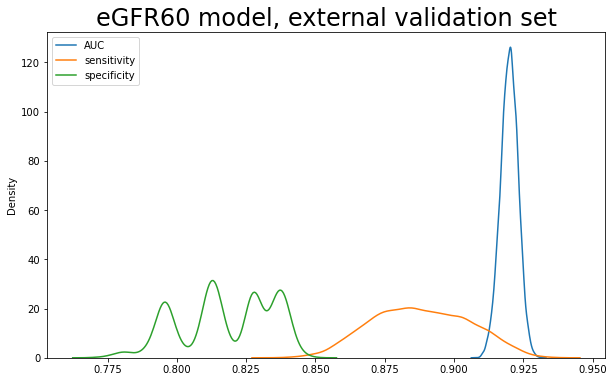

auc mean: 0.92 (0.91-0.93), median:0.92
se  mean: 0.89 (0.86-0.92), median:0.89
sp  mean: 0.82 (0.79-0.84), median:0.82
th  mean: 0.48 (0.42-0.53), median:0.47


In [20]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box_ev, label='AUC') 
sns.kdeplot(se_box_ev, label='sensitivity')
sns.kdeplot(sp_box_ev, label='specificity')
plt.title("eGFR60 model, external validation set", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower_auc = max(0.0, np.percentile(auc_box_ev, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_auc = min(1.0, np.percentile(auc_box_ev, p))
print('auc mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(auc_box_ev), lower_auc, upper_auc, np.median(auc_box_ev)))

p = ((1.0-alpha)/2.0) * 100
lower_se = max(0.0, np.percentile(se_box_ev, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_se = min(1.0, np.percentile(se_box_ev, p))
print('se  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(se_box_ev), lower_se, upper_se, np.median(se_box_ev)))

p = ((1.0-alpha)/2.0) * 100
lower_sp = max(0.0, np.percentile(sp_box_ev, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_sp = min(1.0, np.percentile(sp_box_ev, p))
print('sp  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(sp_box_ev), lower_sp, upper_sp, np.median(sp_box_ev)))

p = ((1.0-alpha)/2.0) * 100
lower_th = max(0.0, np.percentile(th_box_ev, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_th = min(1.0, np.percentile(th_box_ev, p))
print('th  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(th_box_ev), lower_th, upper_th, np.median(th_box_ev)))

### ROC

#### internal

eGFR60 model

Classification Report

Best Threshold=0.473, sensitivity = 0.87, specificity = 0.81, J=0.682
              precision    recall  f1-score   support

      normal       0.99      0.81      0.89     61545
    abnormal       0.25      0.87      0.39      4462

    accuracy                           0.81     66007
   macro avg       0.62      0.84      0.64     66007
weighted avg       0.94      0.81      0.86     66007



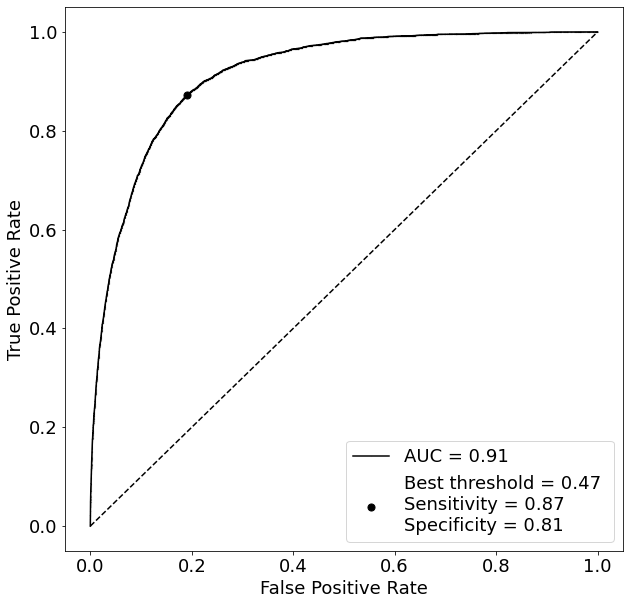

In [21]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_bs['prob']
y_test = X_test_bs['eGFR_ab']
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]

print('eGFR60 model')
print('\nClassification Report\n')
print('Best Threshold=%.3f, sensitivity = %.2f, specificity = %.2f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal']))

#plot roc and best threshold
sens, spec = tpr[ix], 1-fpr[ix]
# plot the roc curve for the model
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["font.size"] = 18
plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')
plt.plot(fpr, tpr, marker='.', color='black', markersize=0.05, label="AUC = %.2f" % roc_auc_score(y_test, y_prob))
plt.scatter(fpr[ix], tpr[ix], marker='o', s=50, color='k', 
            label='Best threshold = %.2f \nSensitivity = %.2f \nSpecificity = %.2f' % (best_thresh, sens, spec))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)

# show the plot
plt.show()

#### external

eGFR60 model, knhanes, external validation

Classification Report

Best Threshold=0.497, sensitivity = 0.88, specificity = 0.83, J=0.703
              precision    recall  f1-score   support

      normal       1.00      0.83      0.90 34743760.49391329
    abnormal       0.10      0.88      0.17 726038.3826888512

    accuracy                           0.83 35469798.87660214
   macro avg       0.55      0.85      0.54 35469798.87660214
weighted avg       0.98      0.83      0.89 35469798.87660214



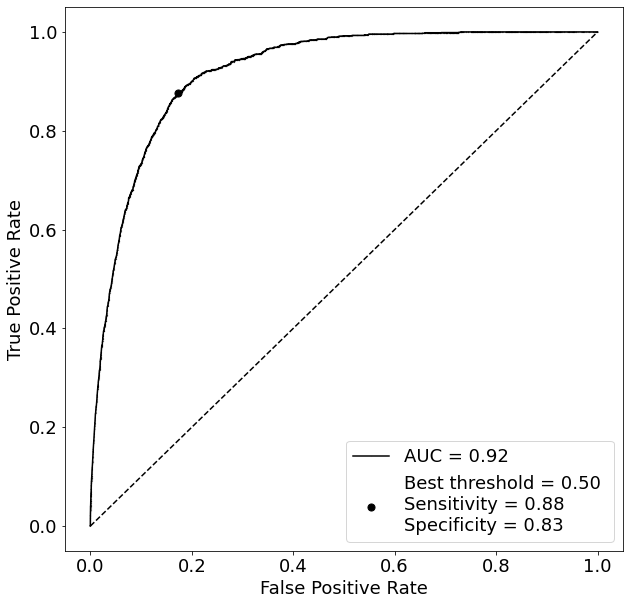

In [22]:
# external validation 

# Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob_ev = model_new.predict_proba(X_test_features_ev)[:,1]
# calculate roc curves
fpr_ev, tpr_ev, thresholds_ev = roc_curve(y_test_ev, y_prob_ev, sample_weight=ev['wt'])
# get the best threshold
J_ev = tpr_ev - fpr_ev
ix_ev = argmax(J_ev)
best_thresh_ev = thresholds_ev[ix_ev]

print('eGFR60 model, knhanes, external validation')
print('\nClassification Report\n')
print('Best Threshold=%.3f, sensitivity = %.2f, specificity = %.2f, J=%.3f' % (best_thresh_ev, tpr_ev[ix_ev], 1-fpr_ev[ix_ev], J_ev[ix_ev]))

y_prob_pred_ev = (y_prob_ev >= best_thresh_ev).astype(bool)
print(classification_report(y_test_ev, y_prob_pred_ev, target_names=['normal', 'abnormal'], sample_weight=ev['wt']))

#plot roc and best threshold
sens_ev, spec_ev = tpr_ev[ix_ev], 1-fpr_ev[ix_ev]
# plot the roc curve for the model
plt.rcParams["figure.figsize"] = (10,10)
plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')
plt.plot(fpr_ev, tpr_ev, marker='.', color='black', markersize=0.05, label="AUC = %.2f" % roc_auc_score(y_test_ev, y_prob_ev, sample_weight=ev['wt']))
plt.scatter(fpr_ev[ix_ev], tpr_ev[ix_ev], marker='o', s=50, color='k', 
            label='Best threshold = %.2f \nSensitivity = %.2f \nSpecificity = %.2f' % (best_thresh_ev, sens_ev, spec_ev))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)

# show the plot
plt.show()

#### both internal and external

Text(0.5, 1.0, 'eGFR60 model ROC')

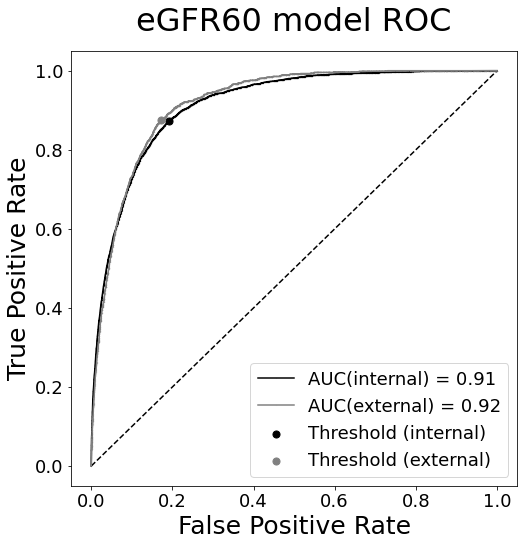

In [23]:
# plot the roc curve for the model
plt.rcParams["figure.figsize"] = (8,8)
plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')

plt.plot(fpr, tpr, marker='.', color='black', markersize=0.05, label="AUC(internal) = %.2f" % roc_auc_score(y_test, y_prob))
plt.scatter(1-spec, sens, marker='o', s=50, color='k'
            , label='Threshold (internal)' 
            #% (best_thresh)
           )

plt.plot(fpr_ev, tpr_ev, marker='.', color='grey', markersize=0.05, label="AUC(external) = %.2f" % roc_auc_score(y_test_ev, y_prob_ev, sample_weight=ev['wt']))
plt.scatter(1-spec_ev, sens_ev, marker='o', s=50, color='grey'
            , label='Threshold (external)' 
            #% (best_thresh_ev)
           )

# axis labels
plt.xlabel('False Positive Rate', fontsize=25)
plt.ylabel('True Positive Rate', fontsize=25)
plt.legend(loc=4, fontsize=18)
plt.title('eGFR60 model ROC', size=32, pad=20)
# show the plot
#plt.show()

# save as png
# plt.savefig('/home/danssa/proj_ua/images/new_4sub/60model_roc.png', dpi=300)

# SHAP value

In [24]:
#SHAP value 

shap.initjs()
print(shap.__version__)

names = pd.read_csv('~/proj_ua/data/knhanes_urine_explain_10types.csv', index_col='var')
background = shap.maskers.Independent(X_train_features_new, max_samples=100)
explainer = shap.TreeExplainer(model_new, model_output='probability', data=X_train_features_new)
shap_values = explainer.shap_values(X_train_features_new)
meaning_dict = names.to_dict()['name']

0.37.0


100%|===================| 153960/154013 [14:14<00:00]        

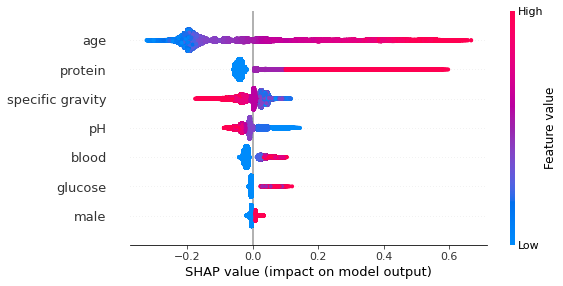

In [25]:
# SHAP, train set
shap.summary_plot(shap_values, X_train_features_new.rename(columns=meaning_dict))

In [26]:
#shap gray version configuration
import matplotlib.colors as colors

gray_val=0.75
cdict = {'red': [(0.0, gray_val, gray_val),
                (1.0, 0.0, 0.0)],
        'green': [(0.0, gray_val, gray_val),
                 (1.0, 0.0, 0.0)],
        'blue': [(0.0, gray_val, gray_val),
                (1.0, 0.0, 0.0)]}
gray2black = colors.LinearSegmentedColormap(name='red', segmentdata=cdict)

In [27]:
# SHAP,test all
shap_values_all = explainer.shap_values(X_test_features)

100%|===================| 65956/66007 [05:37<00:00]        

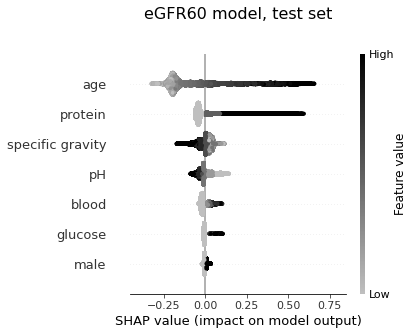

In [28]:
shap.summary_plot(shap_values_all, X_test_features.rename(columns=meaning_dict), show=False, 
                  cmap=plt.get_cmap(gray2black)
                 )
fig = plt.gcf()
fig.set_figheight(5)
fig.set_figwidth(6)

plt.xlim([-0.45,0.85])
plt.title('eGFR60 model, test set', fontsize=16, pad=35)
plt.tight_layout()

#save as png
# plt.savefig('/home/danssa/proj_ua/images/new_4sub/60model_shap.png', dpi=300)

# sub group analysis, internal : DM, HTN, old age, proteinuria

In [44]:
# subset each group
X_test_g1 = X_test_bs.query('dm==1')
X_test_g2 = X_test_bs.query('htn==1')
X_test_g3 = X_test_bs.query('age>=65')
X_test_g4 = X_test_bs.query('he_upro>1')
X_test_g5 = X_test_bs.query('dm==1&age>=65|htn==1&age>=65|he_upro>1&age>=65')

In [45]:
print('total cases, prevalence (cases)')
print('group1: %d, %.1f (%d)' % (len(X_test_g1), sum(X_test_g1['eGFR_ab'])/len(X_test_g1)*100, sum(X_test_g1['eGFR_ab'])))
print('group2: %d, %.1f (%d)' % (len(X_test_g2), sum(X_test_g2['eGFR_ab'])/len(X_test_g2)*100, sum(X_test_g2['eGFR_ab'])))
print('group3: %d, %.1f (%d)' % (len(X_test_g3), sum(X_test_g3['eGFR_ab'])/len(X_test_g3)*100, sum(X_test_g3['eGFR_ab'])))
print('group4: %d, %.1f (%d)' % (len(X_test_g4), sum(X_test_g4['eGFR_ab'])/len(X_test_g4)*100, sum(X_test_g4['eGFR_ab'])))
print('group5: %d, %.1f (%d)' % (len(X_test_g5), sum(X_test_g5['eGFR_ab'])/len(X_test_g5)*100, sum(X_test_g5['eGFR_ab'])))

total cases, prevalence (cases)
group1: 1630, 4.5 (74)
group2: 2642, 2.2 (58)
group3: 10742, 27.8 (2991)
group4: 5651, 26.0 (1467)
group5: 2184, 41.0 (895)


In [53]:
print('train old age & diabetes', 
      sum(X_train.query('age>=65&dm==1')['eGFR_ab'])/len(X_train.query('age>=65&dm==1')),
      sum(X_train.query('age>=65&dm==0')['eGFR_ab'])/len(X_train.query('age>=65&dm==0')))

train old age & diabetes 0.1488095238095238 0.28669868448527874


In [51]:
print('test old age & diabetes',
      sum(X_test_g3.query('dm==1')['eGFR_ab'])/len(X_test_g3.query('dm==1')),
      sum(X_test_g3.query('dm==0')['eGFR_ab'])/len(X_test_g3.query('dm==0')))

test old age & diabetes 0.13529411764705881 0.28311863103249374


## sub1 : DM

In [32]:
# test set
data = X_test_g1

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_s1 = []
th_box_s1 = []
se_box_s1 = []
sp_box_s1 = []

for i in range(n_iterations):
    boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
    auc = roc_auc_score(boot['eGFR_ab'], boot['prob'])
    
    auc_box_s1.append(auc)
    
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(boot['eGFR_ab'], boot['prob'])
    J = tpr - fpr
    ix = argmax(J)
    best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
    
    th_box_s1.append(best_thresh)
    se_box_s1.append(se)
    sp_box_s1.append(sp)

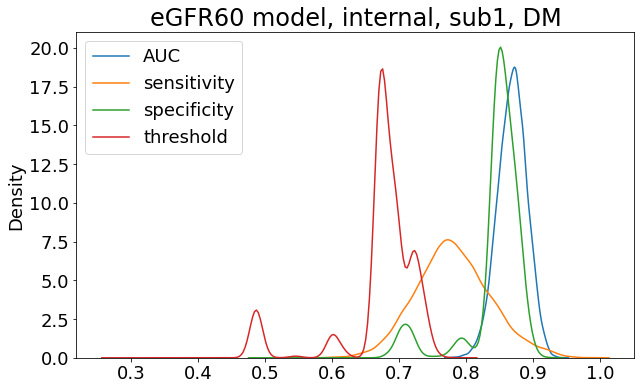

auc mean: 0.87 (0.82-0.91), median:0.87
se  mean: 0.78 (0.68-0.89), median:0.78
sp  mean: 0.84 (0.70-0.89), median:0.85
th  mean: 0.67 (0.49-0.74), median:0.69


In [33]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box_s1, label='AUC') 
sns.kdeplot(se_box_s1, label='sensitivity')
sns.kdeplot(sp_box_s1, label='specificity')
sns.kdeplot(th_box_s1, label='threshold')
plt.title("eGFR60 model, internal, sub1, DM", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower_auc = max(0.0, np.percentile(auc_box_s1, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_auc = min(1.0, np.percentile(auc_box_s1, p))
print('auc mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(auc_box_s1), lower_auc, upper_auc, np.median(auc_box_s1)))

p = ((1.0-alpha)/2.0) * 100
lower_se = max(0.0, np.percentile(se_box_s1, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_se = min(1.0, np.percentile(se_box_s1, p))
print('se  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(se_box_s1), lower_se, upper_se, np.median(se_box_s1)))

p = ((1.0-alpha)/2.0) * 100
lower_sp = max(0.0, np.percentile(sp_box_s1, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_sp = min(1.0, np.percentile(sp_box_s1, p))
print('sp  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(sp_box_s1), lower_sp, upper_sp, np.median(sp_box_s1)))

p = ((1.0-alpha)/2.0) * 100
lower_th = max(0.0, np.percentile(th_box_s1, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_th = min(1.0, np.percentile(th_box_s1, p))
print('th  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(th_box_s1), lower_th, upper_th, np.median(th_box_s1)))

In [34]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_g1['prob']
y_test = X_test_g1['eGFR_ab']

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('eGFR60 model, group1')
print('AUC         : %.2f\nsensitivity : %.2f\nspecificity : %.2f\nThreshold   : %.2f' 
      % (roc_auc_score(y_test, y_prob), tpr[ix], 1-fpr[ix], best_thresh))

print('\nClassification Report\n')
y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal']))

eGFR60 model, group1
AUC         : 0.87
sensitivity : 0.77
specificity : 0.85
Threshold   : 0.67

Classification Report

              precision    recall  f1-score   support

      normal       0.99      0.85      0.91      1556
    abnormal       0.19      0.77      0.31        74

    accuracy                           0.84      1630
   macro avg       0.59      0.81      0.61      1630
weighted avg       0.95      0.84      0.88      1630



## sub2 : HTN

In [35]:
# test set
data = X_test_g2

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_s2 = []
th_box_s2 = []
se_box_s2 = []
sp_box_s2 = []

for i in range(n_iterations):
    boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
    auc = roc_auc_score(boot['eGFR_ab'], boot['prob'])
    
    auc_box_s2.append(auc)
    
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(boot['eGFR_ab'], boot['prob'])
    J = tpr - fpr
    ix = argmax(J)
    best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
    
    th_box_s2.append(best_thresh)
    se_box_s2.append(se)
    sp_box_s2.append(sp)

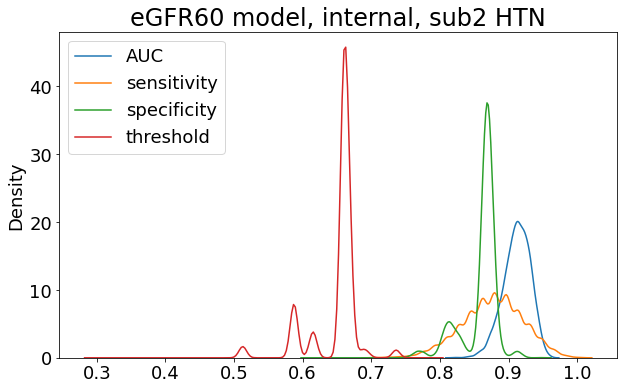

auc mean: 0.91 (0.87-0.95), median:0.91
se  mean: 0.88 (0.79-0.97), median:0.88
sp  mean: 0.86 (0.79-0.89), median:0.87
th  mean: 0.65 (0.59-0.69), median:0.66


In [36]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box_s2, label='AUC') 
sns.kdeplot(se_box_s2, label='sensitivity')
sns.kdeplot(sp_box_s2, label='specificity')
sns.kdeplot(th_box_s2, label="threshold")
plt.title("eGFR60 model, internal, sub2 HTN", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower_auc = max(0.0, np.percentile(auc_box_s2, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_auc = min(1.0, np.percentile(auc_box_s2, p))
print('auc mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(auc_box_s2), lower_auc, upper_auc, np.median(auc_box_s2)))

p = ((1.0-alpha)/2.0) * 100
lower_se = max(0.0, np.percentile(se_box_s2, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_se = min(1.0, np.percentile(se_box_s2, p))
print('se  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(se_box_s2), lower_se, upper_se, np.median(se_box_s2)))

p = ((1.0-alpha)/2.0) * 100
lower_sp = max(0.0, np.percentile(sp_box_s2, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_sp = min(1.0, np.percentile(sp_box_s2, p))
print('sp  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(sp_box_s2), lower_sp, upper_sp, np.median(sp_box_s2)))

p = ((1.0-alpha)/2.0) * 100
lower_th = max(0.0, np.percentile(th_box_s2, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_th = min(1.0, np.percentile(th_box_s2, p))
print('th  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(th_box_s2), lower_th, upper_th, np.median(th_box_s2)))

In [37]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_g2['prob']
y_test = X_test_g2['eGFR_ab']

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('eGFR60 model, group2')
print('AUC         : %.2f\nsensitivity : %.2f\nspecificity : %.2f\nThreshold   : %.2f' 
      % (roc_auc_score(y_test, y_prob), tpr[ix], 1-fpr[ix], best_thresh))

print('\nClassification Report\n')
y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal']))

eGFR60 model, group2
AUC         : 0.91
sensitivity : 0.86
specificity : 0.87
Threshold   : 0.66

Classification Report

              precision    recall  f1-score   support

      normal       1.00      0.87      0.93      2584
    abnormal       0.13      0.86      0.22        58

    accuracy                           0.87      2642
   macro avg       0.56      0.86      0.57      2642
weighted avg       0.98      0.87      0.91      2642



## sub3 : old age, age>=65

In [38]:
# test set
data = X_test_g3

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_s3 = []
th_box_s3 = []
se_box_s3 = []
sp_box_s3 = []

for i in range(n_iterations):
    boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
    auc = roc_auc_score(boot['eGFR_ab'], boot['prob'])
    
    auc_box_s3.append(auc)
    
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(boot['eGFR_ab'], boot['prob'])
    J = tpr - fpr
    ix = argmax(J)
    best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
    
    th_box_s3.append(best_thresh)
    se_box_s3.append(se)
    sp_box_s3.append(sp)

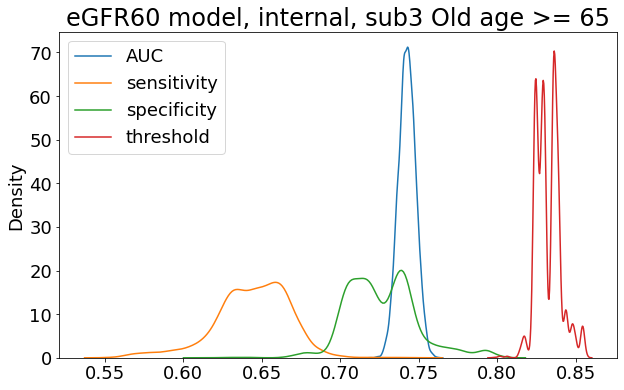

auc mean: 0.74 (0.73-0.75), median:0.74
se  mean: 0.64 (0.58-0.68), median:0.65
sp  mean: 0.73 (0.69-0.78), median:0.72
th  mean: 0.83 (0.82-0.85), median:0.83


In [39]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box_s3, label='AUC') 
sns.kdeplot(se_box_s3, label='sensitivity')
sns.kdeplot(sp_box_s3, label='specificity')
sns.kdeplot(th_box_s3, label='threshold')
plt.title("eGFR60 model, internal, sub3 Old age >= 65", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower_auc = max(0.0, np.percentile(auc_box_s3, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_auc = min(1.0, np.percentile(auc_box_s3, p))
print('auc mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(auc_box_s3), lower_auc, upper_auc, np.median(auc_box_s3)))

p = ((1.0-alpha)/2.0) * 100
lower_se = max(0.0, np.percentile(se_box_s3, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_se = min(1.0, np.percentile(se_box_s3, p))
print('se  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(se_box_s3), lower_se, upper_se, np.median(se_box_s3)))

p = ((1.0-alpha)/2.0) * 100
lower_sp = max(0.0, np.percentile(sp_box_s3, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_sp = min(1.0, np.percentile(sp_box_s3, p))
print('sp  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(sp_box_s3), lower_sp, upper_sp, np.median(sp_box_s3)))

p = ((1.0-alpha)/2.0) * 100
lower_th = max(0.0, np.percentile(th_box_s3, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_th = min(1.0, np.percentile(th_box_s3, p))
print('th  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(th_box_s3), lower_th, upper_th, np.median(th_box_s3)))

In [40]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_g3['prob']
y_test = X_test_g3['eGFR_ab']

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('eGFR60 model, group3')
print('AUC         : %.2f\nsensitivity : %.2f\nspecificity : %.2f\nThreshold   : %.2f' 
      % (roc_auc_score(y_test, y_prob), tpr[ix], 1-fpr[ix], best_thresh))

print('\nClassification Report\n')
y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal']))

eGFR60 model, group3
AUC         : 0.74
sensitivity : 0.63
specificity : 0.74
Threshold   : 0.84

Classification Report

              precision    recall  f1-score   support

      normal       0.84      0.74      0.78      7751
    abnormal       0.48      0.63      0.55      2991

    accuracy                           0.71     10742
   macro avg       0.66      0.68      0.66     10742
weighted avg       0.74      0.71      0.72     10742



## sub4 : proteinuria

In [41]:
# test set
data = X_test_g4

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_s4 = []
th_box_s4 = []
se_box_s4 = []
sp_box_s4 = []

for i in range(n_iterations):
    boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
    auc = roc_auc_score(boot['eGFR_ab'], boot['prob'])
    
    auc_box_s4.append(auc)
    
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(boot['eGFR_ab'], boot['prob'])
    J = tpr - fpr
    ix = argmax(J)
    best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
    
    th_box_s4.append(best_thresh)
    se_box_s4.append(se)
    sp_box_s4.append(sp)

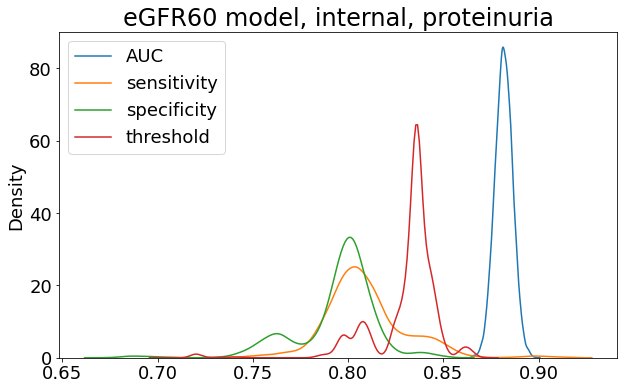

auc mean: 0.88 (0.87-0.89), median:0.88
se  mean: 0.81 (0.77-0.85), median:0.81
sp  mean: 0.79 (0.75-0.83), median:0.80
th  mean: 0.83 (0.80-0.86), median:0.84


In [42]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box_s4, label='AUC') 
sns.kdeplot(se_box_s4, label='sensitivity')
sns.kdeplot(sp_box_s4, label='specificity')
sns.kdeplot(th_box_s4, label='threshold')
plt.title("eGFR60 model, internal, proteinuria", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower_auc = max(0.0, np.percentile(auc_box_s4, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_auc = min(1.0, np.percentile(auc_box_s4, p))
print('auc mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(auc_box_s4), lower_auc, upper_auc, np.median(auc_box_s4)))

p = ((1.0-alpha)/2.0) * 100
lower_se = max(0.0, np.percentile(se_box_s4, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_se = min(1.0, np.percentile(se_box_s4, p))
print('se  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(se_box_s4), lower_se, upper_se, np.median(se_box_s4)))

p = ((1.0-alpha)/2.0) * 100
lower_sp = max(0.0, np.percentile(sp_box_s4, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_sp = min(1.0, np.percentile(sp_box_s4, p))
print('sp  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(sp_box_s4), lower_sp, upper_sp, np.median(sp_box_s4)))

p = ((1.0-alpha)/2.0) * 100
lower_th = max(0.0, np.percentile(th_box_s4, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_th = min(1.0, np.percentile(th_box_s4, p))
print('th  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(th_box_s4), lower_th, upper_th, np.median(th_box_s4)))

In [43]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_g4['prob']
y_test = X_test_g4['eGFR_ab']

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('eGFR60 model, group4')
print('AUC         : %.2f\nsensitivity : %.2f\nspecificity : %.2f\nThreshold   : %.2f' 
      % (roc_auc_score(y_test, y_prob), tpr[ix], 1-fpr[ix], best_thresh))

print('\nClassification Report\n')
y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal']))

eGFR60 model, group4
AUC         : 0.88
sensitivity : 0.80
specificity : 0.80
Threshold   : 0.84

Classification Report

              precision    recall  f1-score   support

      normal       0.92      0.80      0.86      4184
    abnormal       0.58      0.80      0.68      1467

    accuracy                           0.80      5651
   macro avg       0.75      0.80      0.77      5651
weighted avg       0.83      0.80      0.81      5651



## sub5 : age>=65 and (dm or htn or proteinuria)

In [46]:
# test set
data = X_test_g5

# configure bootstrap
n_iterations = 10000
n_size = len(data)

# run bootstrap
auc_box_s4 = []
th_box_s4 = []
se_box_s4 = []
sp_box_s4 = []

for i in range(n_iterations):
    boot = resample(data, n_samples=n_size, replace=True, stratify=data['eGFR_ab'])
    auc = roc_auc_score(boot['eGFR_ab'], boot['prob'])
    
    auc_box_s4.append(auc)
    
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(boot['eGFR_ab'], boot['prob'])
    J = tpr - fpr
    ix = argmax(J)
    best_thresh, se, sp = thresholds[ix], tpr[ix], 1-fpr[ix]
    
    th_box_s4.append(best_thresh)
    se_box_s4.append(se)
    sp_box_s4.append(sp)

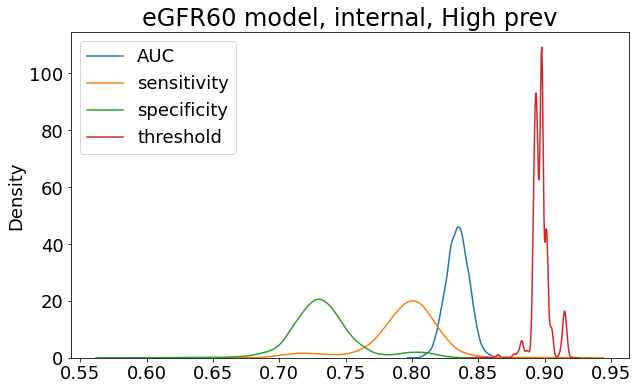

auc mean: 0.83 (0.82-0.85), median:0.83
se  mean: 0.79 (0.71-0.84), median:0.80
sp  mean: 0.73 (0.69-0.81), median:0.73
th  mean: 0.90 (0.88-0.92), median:0.90


In [47]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(auc_box_s4, label='AUC') 
sns.kdeplot(se_box_s4, label='sensitivity')
sns.kdeplot(sp_box_s4, label='specificity')
sns.kdeplot(th_box_s4, label='threshold')
plt.title("eGFR60 model, internal, High prev", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower_auc = max(0.0, np.percentile(auc_box_s4, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_auc = min(1.0, np.percentile(auc_box_s4, p))
print('auc mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(auc_box_s4), lower_auc, upper_auc, np.median(auc_box_s4)))

p = ((1.0-alpha)/2.0) * 100
lower_se = max(0.0, np.percentile(se_box_s4, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_se = min(1.0, np.percentile(se_box_s4, p))
print('se  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(se_box_s4), lower_se, upper_se, np.median(se_box_s4)))

p = ((1.0-alpha)/2.0) * 100
lower_sp = max(0.0, np.percentile(sp_box_s4, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_sp = min(1.0, np.percentile(sp_box_s4, p))
print('sp  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(sp_box_s4), lower_sp, upper_sp, np.median(sp_box_s4)))

p = ((1.0-alpha)/2.0) * 100
lower_th = max(0.0, np.percentile(th_box_s4, p))
p = (alpha+((1.0-alpha)/2.0)) *100
upper_th = min(1.0, np.percentile(th_box_s4, p))
print('th  mean: %.2f (%.2f-%.2f), median:%.2f' % (mean(th_box_s4), lower_th, upper_th, np.median(th_box_s4)))

In [48]:
#Youden’s J statistic. / J = Sensitivity + Specificity – 1
y_prob = X_test_g5['prob']
y_test = X_test_g5['eGFR_ab']

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('eGFR60 model, group5')
print('AUC         : %.2f\nsensitivity : %.2f\nspecificity : %.2f\nThreshold   : %.2f' 
      % (roc_auc_score(y_test, y_prob), tpr[ix], 1-fpr[ix], best_thresh))

print('\nClassification Report\n')
y_prob_pred = (y_prob >= best_thresh).astype(bool)
print(classification_report(y_test, y_prob_pred, target_names=['normal', 'abnormal']))

eGFR60 model, group5
AUC         : 0.83
sensitivity : 0.79
specificity : 0.73
Threshold   : 0.90

Classification Report

              precision    recall  f1-score   support

      normal       0.84      0.73      0.78      1289
    abnormal       0.67      0.79      0.73       895

    accuracy                           0.76      2184
   macro avg       0.75      0.76      0.75      2184
weighted avg       0.77      0.76      0.76      2184



## accuracy in eGFR<60, eGFR<45 and eGFR<30

### internal

### all

In [121]:
X_test_bs['pred'] = np.where(X_test_bs['prob']>=0.48, 1, 0)
X_test_bs['pred'].value_counts()

# 60
X_test_bs60 = X_test_bs.query('eGFR_ckd<60')
X_test_bs60['acc'] = X_test_bs60['eGFR_ab'] == X_test_bs60['pred']
print('60all: %d right: %d ratio: %.1f' % (len(X_test_bs60), sum(X_test_bs60['acc']), sum(X_test_bs60['acc'])/len(X_test_bs60)*100))

#45
X_test_bs45 = X_test_bs.query('eGFR_ckd<45')
X_test_bs45['eGFR_ab45'] = np.where(X_test_bs45['eGFR_ckd']<45,1,0)
X_test_bs45['acc'] = X_test_bs45['eGFR_ab45'] == X_test_bs45['pred']
print('45all: %d right: %d ratio: %.1f' % (len(X_test_bs45), sum(X_test_bs45['acc']), sum(X_test_bs45['acc'])/len(X_test_bs45)*100))

#30
X_test_bs30 = X_test_bs.query('eGFR_ckd<30')
X_test_bs30['eGFR_ab30'] = np.where(X_test_bs30['eGFR_ckd']<30,1,0)
X_test_bs30['acc'] = X_test_bs30['eGFR_ab30'] == X_test_bs30['pred']
print('30all: %d right: %d ratio: %.1f' % (len(X_test_bs30), sum(X_test_bs30['acc']), sum(X_test_bs30['acc'])/len(X_test_bs30)*100))

60all: 4462 right: 3879 ratio: 86.9
45all: 1954 right: 1815 ratio: 92.9
30all: 915 right: 873 ratio: 95.4


In [148]:
# confidence intervals
def cical(box, alpha=0.95):
    p = ((1.0-alpha)/2.0)*100
    lower = max(0.0, np.percentile(box, p))
    p = (alpha+((1.0-alpha)/2.0))*100
    upper = min(1.0, np.percentile(box, p))
   # mean = mean(box)
    median = np.median(box)
    
    return print('mean(ci): %.2f (%.2f-%.2f), median:%.2f' % (mean(box), lower, upper, np.median(box)))

In [139]:
# test set
data = X_test_bs60

# configure bootstrap
n_iterations = 10000
# n_size = len(data)

# run bootstrap
se_all_60, acc = [], []
se_all_45, acc45 = [], []
se_all_30, acc30 = [], []

with tqdm.tqdm(total=len(data)) as pbar:
    for i in range(n_iterations):
        # 60
        boot = resample(data, n_samples=n_size, replace=True, 
                        #stratify=data['eGFR_ab']
                       )
        acc = boot['eGFR_ab'] == boot['pred']
        se = sum(acc)/len(boot)
        se_all_60.append(se)
        
        # 45
        data45 = data.query('eGFR_ckd<45')
        boot45 = resample(data45, n_samples=len(data45), replace=True)
        boot45['eGFR_ab45'] = np.where(boot45['eGFR_ckd']<45,1,0)
        acc45 = boot45['eGFR_ab45'] == boot45['pred']
        se45 = sum(acc45)/len(boot45)
        se_all_45.append(se45)
        
        # 30
        data30 = data.query('eGFR_ckd<30')
        boot30 = resample(data30, n_samples=len(data30), replace=True)
        boot30['eGFR_ab30'] = np.where(boot30['eGFR_ckd']<30,1,0)
        acc30 = boot30['eGFR_ab30'] == boot30['pred']
        se30 = sum(acc30)/len(boot30)
        se_all_30.append(se30)
        
        pbar.update()

10000it [01:02, 159.08it/s]                         


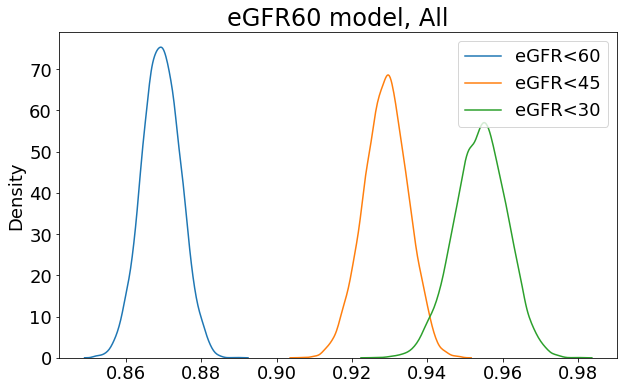

mean(ci): 0.87 (0.86-0.88), median:0.87
mean(ci): 0.93 (0.92-0.94), median:0.93
mean(ci): 0.95 (0.94-0.97), median:0.95


In [149]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(se_all_60, label='eGFR<60') 
sns.kdeplot(se_all_45, label='eGFR<45') 
sns.kdeplot(se_all_30, label='eGFR<30') 
plt.title("eGFR60 model, All", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

cical(se_all_60)
cical(se_all_45)
cical(se_all_30)

### group1, diabetes

In [122]:
X_test_g1['pred'] = np.where(X_test_g1['prob']>=0.67, 1, 0)
X_test_g1['pred'].value_counts()

# 60
X_test_g160 = X_test_g1.query('eGFR_ckd<60')
X_test_g160['acc'] = X_test_g160['eGFR_ab'] == X_test_g160['pred']
print('60all: %d right: %d ratio: %.1f' % (len(X_test_g160), sum(X_test_g160['acc']), sum(X_test_g160['acc'])/len(X_test_g160)*100))

#45
X_test_g145 = X_test_g1.query('eGFR_ckd<45')
X_test_g145['eGFR_ab45'] = np.where(X_test_g145['eGFR_ckd']<45,1,0)
X_test_g145['acc'] = X_test_g145['eGFR_ab45'] == X_test_g145['pred']
print('45all: %d right: %d ratio: %.1f' % (len(X_test_g145), sum(X_test_g145['acc']), sum(X_test_g145['acc'])/len(X_test_g145)*100))

#30
X_test_g130 = X_test_g1.query('eGFR_ckd<30')
X_test_g130['eGFR_ab30'] = np.where(X_test_g130['eGFR_ckd']<30,1,0)
X_test_g130['acc'] = X_test_g130['eGFR_ab30'] == X_test_g130['pred']
print('30all: %d right: %d ratio: %.1f' % (len(X_test_g130), sum(X_test_g130['acc']), sum(X_test_g130['acc'])/len(X_test_g130)*100))

60all: 74 right: 57 ratio: 77.0
45all: 30 right: 25 ratio: 83.3
30all: 18 right: 15 ratio: 83.3


In [150]:
# test set
data = X_test_g160

# configure bootstrap
n_iterations = 10000
# n_size = len(data)

# run bootstrap
se_g1_60, acc = [], []
se_g1_45, acc45 = [], []
se_g1_30, acc30 = [], []

with tqdm.tqdm(total=len(data)) as pbar:
    for i in range(n_iterations):
        # 60
        boot = resample(data, n_samples=n_size, replace=True, 
                        #stratify=data['eGFR_ab']
                       )
        acc = boot['eGFR_ab'] == boot['pred']
        se = sum(acc)/len(boot)
        se_g1_60.append(se)
        
        # 45
        data45 = data.query('eGFR_ckd<45')
        boot45 = resample(data45, n_samples=len(data45), replace=True)
        boot45['eGFR_ab45'] = np.where(boot45['eGFR_ckd']<45,1,0)
        acc45 = boot45['eGFR_ab45'] == boot45['pred']
        se45 = sum(acc45)/len(boot45)
        se_g1_45.append(se45)
        
        # 30
        data30 = data.query('eGFR_ckd<30')
        boot30 = resample(data30, n_samples=len(data30), replace=True)
        boot30['eGFR_ab30'] = np.where(boot30['eGFR_ckd']<30,1,0)
        acc30 = boot30['eGFR_ab30'] == boot30['pred']
        se30 = sum(acc30)/len(boot30)
        se_g1_30.append(se30)
        
        pbar.update()

10000it [00:54, 184.97it/s]                     


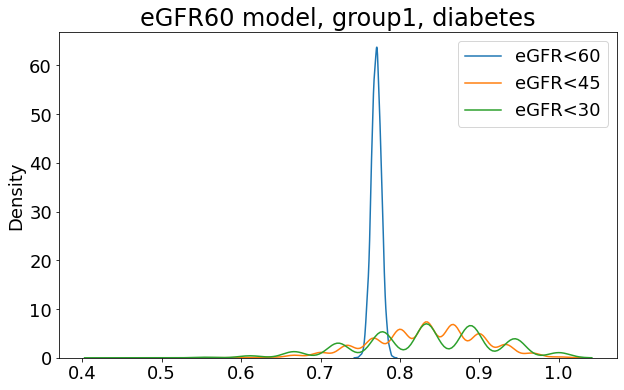

mean(ci): 0.77 (0.76-0.78), median:0.77
mean(ci): 0.83 (0.70-0.97), median:0.83
mean(ci): 0.83 (0.67-1.00), median:0.83


In [151]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(se_g1_60, label='eGFR<60') 
sns.kdeplot(se_g1_45, label='eGFR<45') 
sns.kdeplot(se_g1_30, label='eGFR<30') 
plt.title("eGFR60 model, group1, diabetes", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

cical(se_g1_60)
cical(se_g1_45)
cical(se_g1_30)

### group2, hypertension

In [123]:
X_test_g2['pred'] = np.where(X_test_g2['prob']>=0.65, 1, 0)
X_test_g2['pred'].value_counts()

# 60
X_test_g260 = X_test_g2.query('eGFR_ckd<60')
X_test_g260['acc'] = X_test_g260['eGFR_ab'] == X_test_g260['pred']
print('60all: %d right: %d ratio: %.1f' % (len(X_test_g260), sum(X_test_g260['acc']), sum(X_test_g260['acc'])/len(X_test_g260)*100))

#45
X_test_g245 = X_test_g2.query('eGFR_ckd<45')
X_test_g245['eGFR_ab45'] = np.where(X_test_g245['eGFR_ckd']<45,1,0)
X_test_g245['acc'] = X_test_g245['eGFR_ab45'] == X_test_g245['pred']
print('45all: %d right: %d ratio: %.1f' % (len(X_test_g245), sum(X_test_g245['acc']), sum(X_test_g245['acc'])/len(X_test_g245)*100))

#30
X_test_g230 = X_test_g2.query('eGFR_ckd<30')
X_test_g230['eGFR_ab30'] = np.where(X_test_g230['eGFR_ckd']<30,1,0)
X_test_g230['acc'] = X_test_g230['eGFR_ab30'] == X_test_g230['pred']
print('30all: %d right: %d ratio: %.1f' % (len(X_test_g230), sum(X_test_g230['acc']), sum(X_test_g230['acc'])/len(X_test_g230)*100))

60all: 58 right: 50 ratio: 86.2
45all: 18 right: 18 ratio: 100.0
30all: 9 right: 9 ratio: 100.0


In [152]:
# test set
data = X_test_g260

# configure bootstrap
n_iterations = 10000
# n_size = len(data)

# run bootstrap
se_g2_60, acc = [], []
se_g2_45, acc45 = [], []
se_g2_30, acc30 = [], []

with tqdm.tqdm(total=len(data)) as pbar:
    for i in range(n_iterations):
        # 60
        boot = resample(data, n_samples=n_size, replace=True, 
                        #stratify=data['eGFR_ab']
                       )
        acc = boot['eGFR_ab'] == boot['pred']
        se = sum(acc)/len(boot)
        se_g2_60.append(se)
        
        # 45
        data45 = data.query('eGFR_ckd<45')
        boot45 = resample(data45, n_samples=len(data45), replace=True)
        boot45['eGFR_ab45'] = np.where(boot45['eGFR_ckd']<45,1,0)
        acc45 = boot45['eGFR_ab45'] == boot45['pred']
        se45 = sum(acc45)/len(boot45)
        se_g2_45.append(se45)
        
        # 30
        data30 = data.query('eGFR_ckd<30')
        boot30 = resample(data30, n_samples=len(data30), replace=True)
        boot30['eGFR_ab30'] = np.where(boot30['eGFR_ckd']<30,1,0)
        acc30 = boot30['eGFR_ab30'] == boot30['pred']
        se30 = sum(acc30)/len(boot30)
        se_g2_30.append(se30)
        
        pbar.update()

10000it [00:53, 185.97it/s]                     


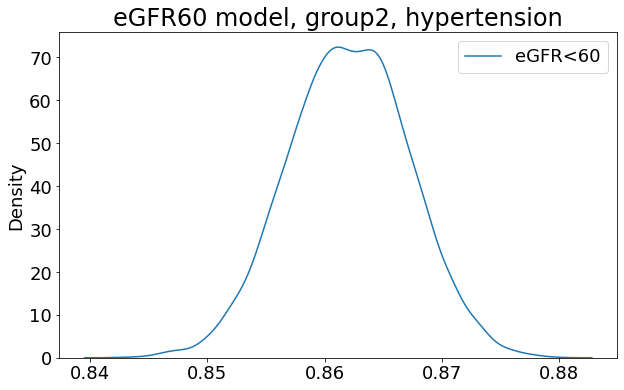

mean(ci): 0.86 (0.85-0.87), median:0.86
mean(ci): 1.00 (1.00-1.00), median:1.00
mean(ci): 1.00 (1.00-1.00), median:1.00


In [153]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(se_g2_60, label='eGFR<60') 
sns.kdeplot(se_g2_45, label='eGFR<45') 
sns.kdeplot(se_g2_30, label='eGFR<30') 
plt.title("eGFR60 model, group2, hypertension", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

cical(se_g2_60)
cical(se_g2_45)
cical(se_g2_30)

### group3, old age >= 65

In [124]:
X_test_g3['pred'] = np.where(X_test_g3['prob']>=0.83, 1, 0)
X_test_g3['pred'].value_counts()

# 60
X_test_g360 = X_test_g3.query('eGFR_ckd<60')
X_test_g360['acc'] = X_test_g360['eGFR_ab'] == X_test_g360['pred']
print('60all: %d right: %d ratio: %.1f' % (len(X_test_g360), sum(X_test_g360['acc']), sum(X_test_g360['acc'])/len(X_test_g360)*100))

#45
X_test_g345 = X_test_g3.query('eGFR_ckd<45')
X_test_g345['eGFR_ab45'] = np.where(X_test_g345['eGFR_ckd']<45,1,0)
X_test_g345['acc'] = X_test_g345['eGFR_ab45'] == X_test_g345['pred']
print('45all: %d right: %d ratio: %.1f' % (len(X_test_g345), sum(X_test_g345['acc']), sum(X_test_g345['acc'])/len(X_test_g345)*100))

#30
X_test_g330 = X_test_g3.query('eGFR_ckd<30')
X_test_g330['eGFR_ab30'] = np.where(X_test_g330['eGFR_ckd']<30,1,0)
X_test_g330['acc'] = X_test_g330['eGFR_ab30'] == X_test_g330['pred']
print('30all: %d right: %d ratio: %.1f' % (len(X_test_g330), sum(X_test_g330['acc']), sum(X_test_g330['acc'])/len(X_test_g330)*100))

60all: 2991 right: 1941 ratio: 64.9
45all: 1291 right: 1041 ratio: 80.6
30all: 556 right: 499 ratio: 89.7


In [155]:
# test set
data = X_test_g360

# configure bootstrap
n_iterations = 10000
# n_size = len(data)

# run bootstrap
se_g3_60, acc = [], []
se_g3_45, acc45 = [], []
se_g3_30, acc30 = [], []

with tqdm.tqdm(total=len(data)) as pbar:
    for i in range(n_iterations):
        # 60
        boot = resample(data, n_samples=n_size, replace=True, 
                        #stratify=data['eGFR_ab']
                       )
        acc = boot['eGFR_ab'] == boot['pred']
        se = sum(acc)/len(boot)
        se_g3_60.append(se)
        
        # 45
        data45 = data.query('eGFR_ckd<45')
        boot45 = resample(data45, n_samples=len(data45), replace=True)
        boot45['eGFR_ab45'] = np.where(boot45['eGFR_ckd']<45,1,0)
        acc45 = boot45['eGFR_ab45'] == boot45['pred']
        se45 = sum(acc45)/len(boot45)
        se_g3_45.append(se45)
        
        # 30
        data30 = data.query('eGFR_ckd<30')
        boot30 = resample(data30, n_samples=len(data30), replace=True)
        boot30['eGFR_ab30'] = np.where(boot30['eGFR_ckd']<30,1,0)
        acc30 = boot30['eGFR_ab30'] == boot30['pred']
        se30 = sum(acc30)/len(boot30)
        se_g3_30.append(se30)
        
        pbar.update()

10000it [00:59, 168.59it/s]                         


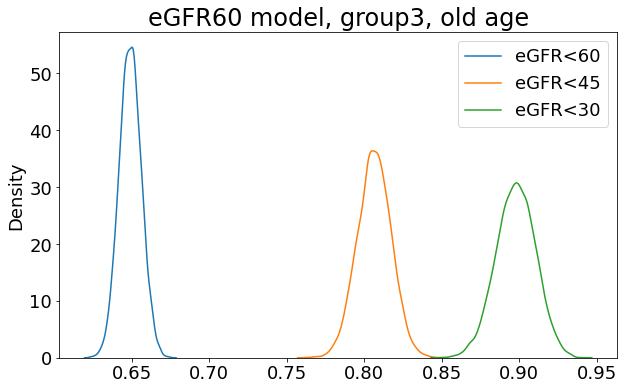

mean(ci): 0.65 (0.64-0.66), median:0.65
mean(ci): 0.81 (0.78-0.83), median:0.81
mean(ci): 0.90 (0.87-0.92), median:0.90


In [156]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(se_g3_60, label='eGFR<60') 
sns.kdeplot(se_g3_45, label='eGFR<45') 
sns.kdeplot(se_g3_30, label='eGFR<30') 
plt.title("eGFR60 model, group3, old age", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

cical(se_g3_60)
cical(se_g3_45)
cical(se_g3_30)

### group4, proteinuria

In [125]:
X_test_g4['pred'] = np.where(X_test_g4['prob']>=0.83, 1, 0)
X_test_g4['pred'].value_counts()

# 60
X_test_g460 = X_test_g4.query('eGFR_ckd<60')
X_test_g460['acc'] = X_test_g460['eGFR_ab'] == X_test_g460['pred']
print('60all: %d right: %d ratio: %.1f' % (len(X_test_g460), sum(X_test_g460['acc']), sum(X_test_g460['acc'])/len(X_test_g460)*100))

#45
X_test_g445 = X_test_g4.query('eGFR_ckd<45')
X_test_g445['eGFR_ab45'] = np.where(X_test_g445['eGFR_ckd']<45,1,0)
X_test_g445['acc'] = X_test_g445['eGFR_ab45'] == X_test_g445['pred']
print('45all: %d right: %d ratio: %.1f' % (len(X_test_g445), sum(X_test_g445['acc']), sum(X_test_g445['acc'])/len(X_test_g445)*100))

#30
X_test_g430 = X_test_g4.query('eGFR_ckd<30')
X_test_g430['eGFR_ab30'] = np.where(X_test_g430['eGFR_ckd']<30,1,0)
X_test_g430['acc'] = X_test_g430['eGFR_ab30'] == X_test_g430['pred']
print('30all: %d right: %d ratio: %.1f' % (len(X_test_g430), sum(X_test_g430['acc']), sum(X_test_g430['acc'])/len(X_test_g430)*100))

60all: 1467 right: 1185 ratio: 80.8
45all: 994 right: 846 ratio: 85.1
30all: 632 right: 543 ratio: 85.9


In [157]:
# test set
data = X_test_g460

# configure bootstrap
n_iterations = 10000
# n_size = len(data)

# run bootstrap
se_g4_60, acc = [], []
se_g4_45, acc45 = [], []
se_g4_30, acc30 = [], []

with tqdm.tqdm(total=len(data)) as pbar:
    for i in range(n_iterations):
        # 60
        boot = resample(data, n_samples=n_size, replace=True, 
                        #stratify=data['eGFR_ab']
                       )
        acc = boot['eGFR_ab'] == boot['pred']
        se = sum(acc)/len(boot)
        se_g4_60.append(se)
        
        # 45
        data45 = data.query('eGFR_ckd<45')
        boot45 = resample(data45, n_samples=len(data45), replace=True)
        boot45['eGFR_ab45'] = np.where(boot45['eGFR_ckd']<45,1,0)
        acc45 = boot45['eGFR_ab45'] == boot45['pred']
        se45 = sum(acc45)/len(boot45)
        se_g4_45.append(se45)
        
        # 30
        data30 = data.query('eGFR_ckd<30')
        boot30 = resample(data30, n_samples=len(data30), replace=True)
        boot30['eGFR_ab30'] = np.where(boot30['eGFR_ckd']<30,1,0)
        acc30 = boot30['eGFR_ab30'] == boot30['pred']
        se30 = sum(acc30)/len(boot30)
        se_g4_30.append(se30)
        
        pbar.update()

10000it [01:00, 165.46it/s]                         


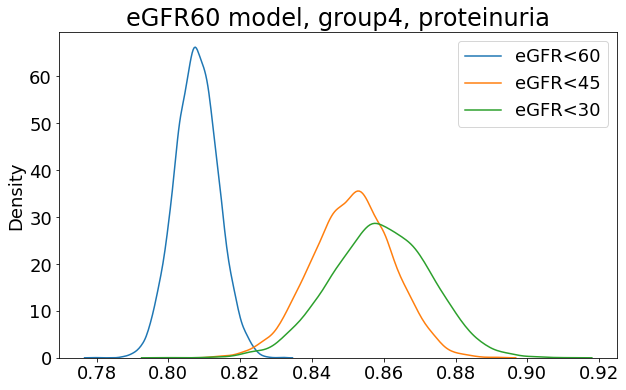

mean(ci): 0.81 (0.80-0.82), median:0.81
mean(ci): 0.85 (0.83-0.87), median:0.85
mean(ci): 0.86 (0.83-0.88), median:0.86


In [158]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(se_g4_60, label='eGFR<60') 
sns.kdeplot(se_g4_45, label='eGFR<45') 
sns.kdeplot(se_g4_30, label='eGFR<30') 
plt.title("eGFR60 model, group4, proteinuria", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

cical(se_g4_60)
cical(se_g4_45)
cical(se_g4_30)

### group5, high prevalence

In [126]:
X_test_g5['pred'] = np.where(X_test_g5['prob']>=0.90, 1, 0)
X_test_g5['pred'].value_counts()

# 60
X_test_g560 = X_test_g5.query('eGFR_ckd<60')
X_test_g560['acc'] = X_test_g560['eGFR_ab'] == X_test_g560['pred']
print('60all: %d right: %d ratio: %.1f' % (len(X_test_g560), sum(X_test_g560['acc']), sum(X_test_g560['acc'])/len(X_test_g560)*100))

#45
X_test_g545 = X_test_g5.query('eGFR_ckd<45')
X_test_g545['eGFR_ab45'] = np.where(X_test_g545['eGFR_ckd']<45,1,0)
X_test_g545['acc'] = X_test_g545['eGFR_ab45'] == X_test_g545['pred']
print('45all: %d right: %d ratio: %.1f' % (len(X_test_g545), sum(X_test_g545['acc']), sum(X_test_g545['acc'])/len(X_test_g545)*100))

#30
X_test_g530 = X_test_g5.query('eGFR_ckd<30')
X_test_g530['eGFR_ab30'] = np.where(X_test_g530['eGFR_ckd']<30,1,0)
X_test_g530['acc'] = X_test_g530['eGFR_ab30'] == X_test_g530['pred']
print('30all: %d right: %d ratio: %.1f' % (len(X_test_g530), sum(X_test_g530['acc']), sum(X_test_g530['acc'])/len(X_test_g530)*100))

60all: 895 right: 696 ratio: 77.8
45all: 573 right: 495 ratio: 86.4
30all: 343 right: 313 ratio: 91.3


In [159]:
# test set
data = X_test_g560

# configure bootstrap
n_iterations = 10000
# n_size = len(data)

# run bootstrap
se_g5_60, acc = [], []
se_g5_45, acc45 = [], []
se_g5_30, acc30 = [], []

with tqdm.tqdm(total=len(data)) as pbar:
    for i in range(n_iterations):
        # 60
        boot = resample(data, n_samples=n_size, replace=True, 
                        #stratify=data['eGFR_ab']
                       )
        acc = boot['eGFR_ab'] == boot['pred']
        se = sum(acc)/len(boot)
        se_g5_60.append(se)
        
        # 45
        data45 = data.query('eGFR_ckd<45')
        boot45 = resample(data45, n_samples=len(data45), replace=True)
        boot45['eGFR_ab45'] = np.where(boot45['eGFR_ckd']<45,1,0)
        acc45 = boot45['eGFR_ab45'] == boot45['pred']
        se45 = sum(acc45)/len(boot45)
        se_g5_45.append(se45)
        
        # 30
        data30 = data.query('eGFR_ckd<30')
        boot30 = resample(data30, n_samples=len(data30), replace=True)
        boot30['eGFR_ab30'] = np.where(boot30['eGFR_ckd']<30,1,0)
        acc30 = boot30['eGFR_ab30'] == boot30['pred']
        se30 = sum(acc30)/len(boot30)
        se_g5_30.append(se30)
        
        pbar.update()

10000it [00:58, 171.30it/s]                       


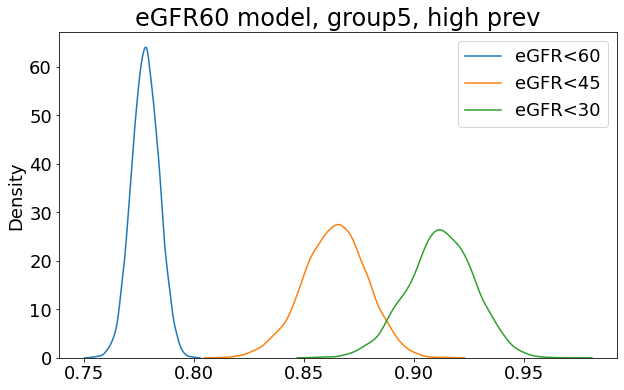

mean(ci): 0.78 (0.77-0.79), median:0.78
mean(ci): 0.86 (0.83-0.89), median:0.86
mean(ci): 0.91 (0.88-0.94), median:0.91


In [160]:
# Kernel Density Estimate Plot  
plt.rcParams['figure.figsize'] = [10, 6] 
sns.kdeplot(se_g5_60, label='eGFR<60') 
sns.kdeplot(se_g5_45, label='eGFR<45') 
sns.kdeplot(se_g5_30, label='eGFR<30') 
plt.title("eGFR60 model, group5, high prev", fontsize=24)
#plt.xlim(0.8,1)
plt.legend()
plt.show()

cical(se_g5_60)
cical(se_g5_45)
cical(se_g5_30)

In [170]:
df_se_trend = pd.DataFrame({
    'eGFR' : ['eGFR<60', 'eGFR<45', 'eGFR<30',
             'eGFR<60', 'eGFR<45', 'eGFR<30',
             'eGFR<60', 'eGFR<45', 'eGFR<30',
             'eGFR<60', 'eGFR<45', 'eGFR<30',
             'eGFR<60', 'eGFR<45', 'eGFR<30',
             'eGFR<60', 'eGFR<45', 'eGFR<30'],
    
    'se'   : [0.87, 0.93, 0.95, 
              0.77, 0.83, 0.83, 
              0.86, 1.00, 1.00, 
              0.65, 0.81, 0.90, 
              0.81, 0.85, 0.86, 
              0.78, 0.86, 0.91],
    
    'lower' : [0.86, 0.92, 0.94,
              0.76, 0.70, 0.67,
              0.85, 1.00, 1.00,
              0.64, 0.78, 0.87,
              0.80, 0.83, 0.83,
              0.77, 0.83, 0.88],
    
    'upper' : [0.88, 0.94, 0.97,
              0.78, 0.97, 1.00,
              0.87, 1.00, 1.00,
              0.66, 0.83, 0.92,
              0.82, 0.87, 0.88,
              0.79, 0.89, 0.94],
    
    'group'  : ['All', 'All', 'All',
               'Diabetes', 'Diabetes', 'Diabetes',
               'Hypertension', 'Hypertension', 'Hypertension',
               'Old age', 'Old age', 'Old age',
               'Proteinuria','Proteinuria','Proteinuria',
               'High prev','High prev','High prev']
})
df_se_trend['lower'] = df_se_trend['se'] - df_se_trend['lower']
df_se_trend['upper'] = df_se_trend['upper'] - df_se_trend['se']
df_se_trend

,eGFR,se,lower,upper,group
0,eGFR<60,0.87,0.01,0.01,All
1,eGFR<45,0.93,0.01,0.01,All
2,eGFR<30,0.95,0.01,0.02,All
3,eGFR<60,0.77,0.01,0.01,Diabetes
4,eGFR<45,0.83,0.13,0.14,Diabetes
5,eGFR<30,0.83,0.16,0.17,Diabetes
6,eGFR<60,0.86,0.01,0.01,Hypertension
7,eGFR<45,1.00,0.00,0.00,Hypertension
8,eGFR<30,1.00,0.00,0.00,Hypertension
9,eGFR<60,0.65,0.01,0.01,Old age


In [215]:
df_se_trend_sub = df_se_trend.query('group=="All"|group=="Old age"|group=="High prev"')
df_se_trend_sub

,eGFR,se,lower,upper,group
0,eGFR<60,0.87,0.01,0.01,All
1,eGFR<45,0.93,0.01,0.01,All
2,eGFR<30,0.95,0.01,0.02,All
9,eGFR<60,0.65,0.01,0.01,Old age
10,eGFR<45,0.81,0.03,0.02,Old age
11,eGFR<30,0.90,0.03,0.02,Old age
15,eGFR<60,0.78,0.01,0.01,High prev
16,eGFR<45,0.86,0.03,0.03,High prev
17,eGFR<30,0.91,0.03,0.03,High prev


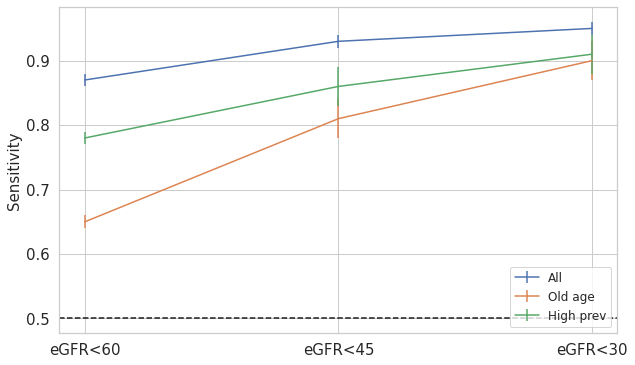

In [216]:
# trends of sensitivities plot

fig,ax = plt.subplots()
sns.set(style= "whitegrid")

df = df_se_trend_sub
lvls = df.group.unique()
for i in lvls:
    ax.errorbar(x = df[df['group']==i]["eGFR"],
                y=df[df['group']==i]["se"], 
                yerr=[df[df['group']==i]["lower"], df[df['group']==i]["lower"]],
               label=i)

ax.axhline(y=0.5 , color='k', linestyle='--')
ax.legend(loc=4, prop={'size':12})
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_ylabel('Sensitivity', fontsize=15)

plt.show()

### external

### all

In [114]:
X_test_bs_ev['pred'] = np.where(X_test_bs_ev['prob']>=0.48, 1, 0)
X_test_bs_ev['pred'].value_counts()

#60
X_test_bs_ev60 = X_test_bs_ev.query('eGFR_ckd<60')
X_test_bs_ev60['acc'] = X_test_bs_ev60['eGFR_ab'] == X_test_bs_ev60['pred']
print('60all: %.f right: %.f ratio: %.1f' % 
      (sum(X_test_bs_ev60['wt']), sum(X_test_bs_ev60.query('acc==1')['wt']), sum(X_test_bs_ev60.query('acc==1')['wt'])/sum(X_test_bs_ev60['wt'])*100))

#45
X_test_bs_ev45 = X_test_bs_ev.query('eGFR_ckd<45')
X_test_bs_ev45['eGFR_ab45'] = np.where(X_test_bs_ev45['eGFR_ckd']<45,1,0)
X_test_bs_ev45['acc'] = X_test_bs_ev45['eGFR_ab'] == X_test_bs_ev45['pred']
print('45all: %.f right: %.f ratio: %.1f' % 
      (sum(X_test_bs_ev45['wt']), sum(X_test_bs_ev45.query('acc==1')['wt']), sum(X_test_bs_ev45.query('acc==1')['wt'])/sum(X_test_bs_ev45['wt'])*100))

#30
X_test_bs_ev30 = X_test_bs_ev.query('eGFR_ckd<30')
X_test_bs_ev30['eGFR_ab30'] = np.where(X_test_bs_ev30['eGFR_ckd']<30,1,0)
X_test_bs_ev30['acc'] = X_test_bs_ev30['eGFR_ab'] == X_test_bs_ev30['pred']
print('30all: %.f right: %.f ratio: %.1f' % 
      (sum(X_test_bs_ev30['wt']), sum(X_test_bs_ev30.query('acc==1')['wt']), sum(X_test_bs_ev30.query('acc==1')['wt'])/sum(X_test_bs_ev30['wt'])*100))

60all: 726038 right: 638047 ratio: 87.9
45all: 170449 right: 155414 ratio: 91.2
30all: 55485 right: 49078 ratio: 88.5
